# 3. Preparación de los datos y tarea de regresión

## 3.1 Preparación de los datos

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings


# Scikit-learn: preparación de los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score


In [12]:

def load_and_info(file_path):
    """
    Cargamos el fichero CSV y mostramos información sobre valores ausentes, únicos, tipo de datos y valores
    """
    df = pd.read_csv(file_path)
    
    info = []
    for col in df.columns:
        data_type = str(df[col].dtype)
        missing = np.sum(pd.isna(df[col]))
        unique = df[col].nunique()
        
        # Obtenemos las categorías para variables categoricas y valores aleatorios en las numéricas
        if data_type == 'object':
            sample = df[col].dropna().unique().tolist()  # Valores únicos para las categóricas
        else:
            sample = df[col].dropna().unique()[:5].tolist()  # Los primeros 5 valores únicos para las numéricas
        
        info.append([col, data_type, missing, unique, sample])
    
    info_df = pd.DataFrame(info)
    info_df.columns = ['Column', 'Dtype', 'Missing', 'Unique', 'Sample values']
    
    # Mostramos las columnas, con información sobre valores ausentes, únicos y tipo de datos
    display(info_df)
    print("\nEl juego de datos contiene {} variables y {} observaciones, de las cuales {} son duplicadas.".format(df.shape[1], df.shape[0], len(df) - df.duplicated().count()))

    # Devolvemos el dataframe para su uso
    return df

In [13]:
df = load_and_info('df_investig_INR.csv')

,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
2,CALCI,float64,0,53,"[7.52, 8.54, 2.21, 8.96, 9.12]"
3,HEMOGLOBINA,float64,0,93,"[10.3, 12.24, 8.7, 13.3, 14.0]"
4,VCM,float64,0,105,"[95.7, 103.26, 86.4, 80.6, 95.5]"
5,HEMATOCRIT,float64,0,108,"[31.8, 36.65, 43.2, 40.25, 41.93]"
6,PLAQUETES,float64,0,101,"[192.0, 177.36, 220.0, 200.0, 168.33]"
7,DIAGNÒSTIC_ASSOCIAT,object,0,20,"[FA_NE, Flutter_NE, Valv_Aort_NReum_NE, EP_Oth..."
8,IMC,float64,0,106,"[27.33, 19.751666666666665, 27.425, 24.94, 34.13]"
9,HB_GLICOSILADA_A1C,float64,0,21,"[6.22, 8.0, 6.2, 6.3, 6.5]"



El juego de datos contiene 21 variables y 133 observaciones, de las cuales 0 son duplicadas.


### División en las muestras de entrenamiento, validación, calibración y prueba

In [14]:
# Construcción de los conjuntos de entrenamiento, validación, calibración y de prueba
X = df.drop('INR', axis=1)
y = df['INR']

from sklearn.model_selection import train_test_split


# Separamos entrenamiento de prueba, 75-25
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.25, random_state=23)

# Separamos el set de entrenamiento nuevamente para obtener el de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=23)

# Separamos el set de prueba nuevamente para obtener el de calibración, el 20% del 25%, es decir 20/25=0.8
X_test, X_cal, y_test, y_cal = train_test_split(X_test_full, y_test_full, test_size=0.8, random_state=23)

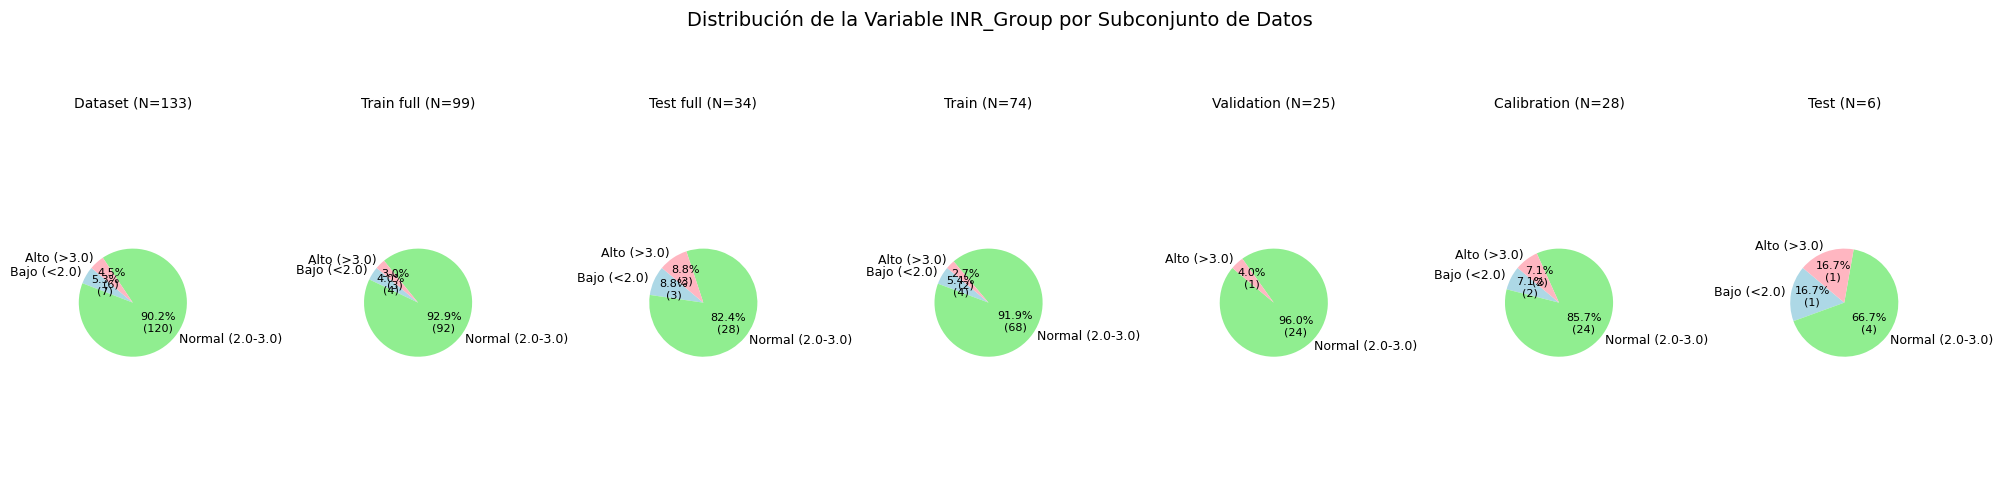

In [15]:


# Supongamos que df_investig_INR es tu DataFrame principal (usado en la sección anterior)
# Necesitas asegurarte de que 'df_investig_INR' y las variables 'y_train_full', 'y_test_full', 
# 'y_train', 'y_val', 'y_cal', 'y_test' están correctamente definidas en tu entorno.

# --- Definición de la función de agrupamiento ---
def create_inr_group(data_series):
    """Crea la columna categórica INR_Group a partir de una serie de datos INR."""
    target_col = 'INR'
    
    # Se ajustan los bins para que el rango Normal sea [2.0, 3.0]
    # Usamos 3.0 + 1e-6 para incluir 3.0 en el rango Normal cuando right=False (intervalo abierto a la derecha)
    min_val = data_series.min() if not data_series.empty else -1
    max_val = data_series.max() if not data_series.empty else 4
    
    # Aseguramos que los bins cubran el rango de los datos si es necesario, 
    # aunque los límites principales son fijos
    bins = [min(min_val - 1, 0), 2.0, 3.0 + 1e-6, max(max_val + 1, 5)]
    
    labels = ['Bajo (<2.0)', 'Normal (2.0-3.0)', 'Alto (>3.0)']
    
    # Filtramos la serie para eliminar posibles NaNs si es necesario antes de agrupar
    data_series = data_series.dropna()
    
    if data_series.empty:
        return pd.Series([], dtype='category')
        
    return pd.cut(
        data_series, 
        bins=bins, 
        labels=labels, 
        right=False, # El intervalo es [a, b)
        include_lowest=True
    ).astype('category')

# --- Aplicación de la función a los datasets ---

# Aplicar la agrupación a cada subconjunto de datos
datasets = [
    df['INR'], # Usar el DataFrame completo para obtener el 'INR_Group' general
    y_train_full, 
    y_test_full, 
    y_train, 
    y_val, 
    y_cal, 
    y_test
]

# Convertir cada serie de 'INR' a su respectivo 'INR_Group'
grouped_datasets = [create_inr_group(ds) for ds in datasets]

titles = ["Dataset", "Train full", "Test full", "Train", "Validation", "Calibration", "Test"]

# --- Generación de los gráficos de pastel ---

# Definir colores para las categorías (consistentes en todos los gráficos)
# Asegúrate de que el orden sea 'Bajo', 'Normal', 'Alto'
category_colors = {
    'Bajo (<2.0)': '#ADD8E6',   # Azul claro
    'Normal (2.0-3.0)': '#90EE90', # Verde claro
    'Alto (>3.0)': '#FFB6C1'      # Rosa claro
}
# Obtener las etiquetas en el orden deseado
category_labels = ['Bajo (<2.0)', 'Normal (2.0-3.0)', 'Alto (>3.0)']
color_list = [category_colors[label] for label in category_labels]

fig, axs = plt.subplots(1, 7, figsize=(20, 5)) # Ajuste de tamaño para mejor visualización

for i in range(len(grouped_datasets)):
    # Contar la ocurrencia de cada grupo categórico
    # Usar .value_counts() con .reindex() para asegurar que todas las categorías 
    # y el orden sean consistentes, incluso si una categoría no tiene datos.
    class_counts = grouped_datasets[i].value_counts().reindex(category_labels, fill_value=0)
    
    # Filtrar las categorías con conteo > 0 para el plot
    counts_to_plot = class_counts[class_counts > 0]
    labels_to_plot = counts_to_plot.index.tolist()
    colors_to_plot = [category_colors[label] for label in labels_to_plot]
    
    ax = axs[i]
    
    # Solo graficar si hay datos
    if not counts_to_plot.empty:
        wedges, _, autotexts = ax.pie(
            counts_to_plot, 
            labels=labels_to_plot, 
            autopct='%1.1f%%', 
            startangle=140, 
            colors=colors_to_plot,
            textprops={'fontsize': 9} # Tamaño de fuente de la etiqueta para mejor ajuste
        )
        
        # Añadimos número de ejemplos junto con el porcentaje por clase
        for autotext, count in zip(autotexts, counts_to_plot):
            autotext.set_text(f"{autotext.get_text()}\n({count})")
            autotext.set_fontsize(8) # Tamaño de fuente del porcentaje/conteo
    else:
        # Mostrar un mensaje si el subconjunto está vacío
        ax.text(0.5, 0.5, 'Sin Datos', ha='center', va='center', fontsize=12)

    ax.set_title(titles[i] + " (N=" + str(len(datasets[i])) + ")", fontsize=10)
    ax.axis("equal")

plt.suptitle("Distribución de la Variable INR_Group por Subconjunto de Datos", fontsize=14, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajuste para el supertítulo
plt.show()

### Codificación de las variables categóricas

In [16]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()
print(categorical)

['DIAGNÒSTIC_ASSOCIAT']


In [17]:
# OneHotEncoder para codificar en variables binarias y devolver un array
encoder = OneHotEncoder(sparse_output=False)

# Configuramos un transformer para devolver un dataframe y evitar las columnas numéricas
# No es necesario añadir prefijos a las columnas, ya que serán unicas
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical),],
    remainder='passthrough',                       # keep any other columns unchanged
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")

ohe.fit(X_train)
X_train_processed = ohe.transform(X_train)

In [18]:
# Filtramos las columnas que han sido codificadas, esto es, contienen _ en el nombre
encoded_cols = [col for col in X_train_processed.columns if "_" in col]

display(X_train_processed[encoded_cols])

,DIAGNÒSTIC_ASSOCIAT_Anticoagulant_LT,DIAGNÒSTIC_ASSOCIAT_Arritmia_NE,DIAGNÒSTIC_ASSOCIAT_EP_Other_No_CorPulm,DIAGNÒSTIC_ASSOCIAT_Estenosi_Aort_NReum,DIAGNÒSTIC_ASSOCIAT_FA_Cron,DIAGNÒSTIC_ASSOCIAT_FA_NE,DIAGNÒSTIC_ASSOCIAT_FA_Parox,DIAGNÒSTIC_ASSOCIAT_FA_Perm,DIAGNÒSTIC_ASSOCIAT_Flebitis_Profunda,DIAGNÒSTIC_ASSOCIAT_HSD_NE,...,DIAGNÒSTIC_ASSOCIAT_SPT_NoComp_NE,DIAGNÒSTIC_ASSOCIAT_Sincop,DIAGNÒSTIC_ASSOCIAT_Taquicardia_Parox_NE,DIAGNÒSTIC_ASSOCIAT_Valv_Aort_NReum_NE,HB_GLICOSILADA_A1C,CRIBRATGE_ALIMENTACIÓ,VALORACIÓ_AUDIT_C,NT_PROBNP,CREATINA_KINASA_CK,FREQ_CARDIACA
56,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,71.670000
29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,78.428571
26,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,78.333333
62,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,66.000000
95,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1386.0,63.1,91.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,79.000000
13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,2.00,0.21,922.5,63.1,60.400000
57,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,1660.5,63.1,77.800000
92,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.22,1.44,0.21,4643.0,63.1,78.833333


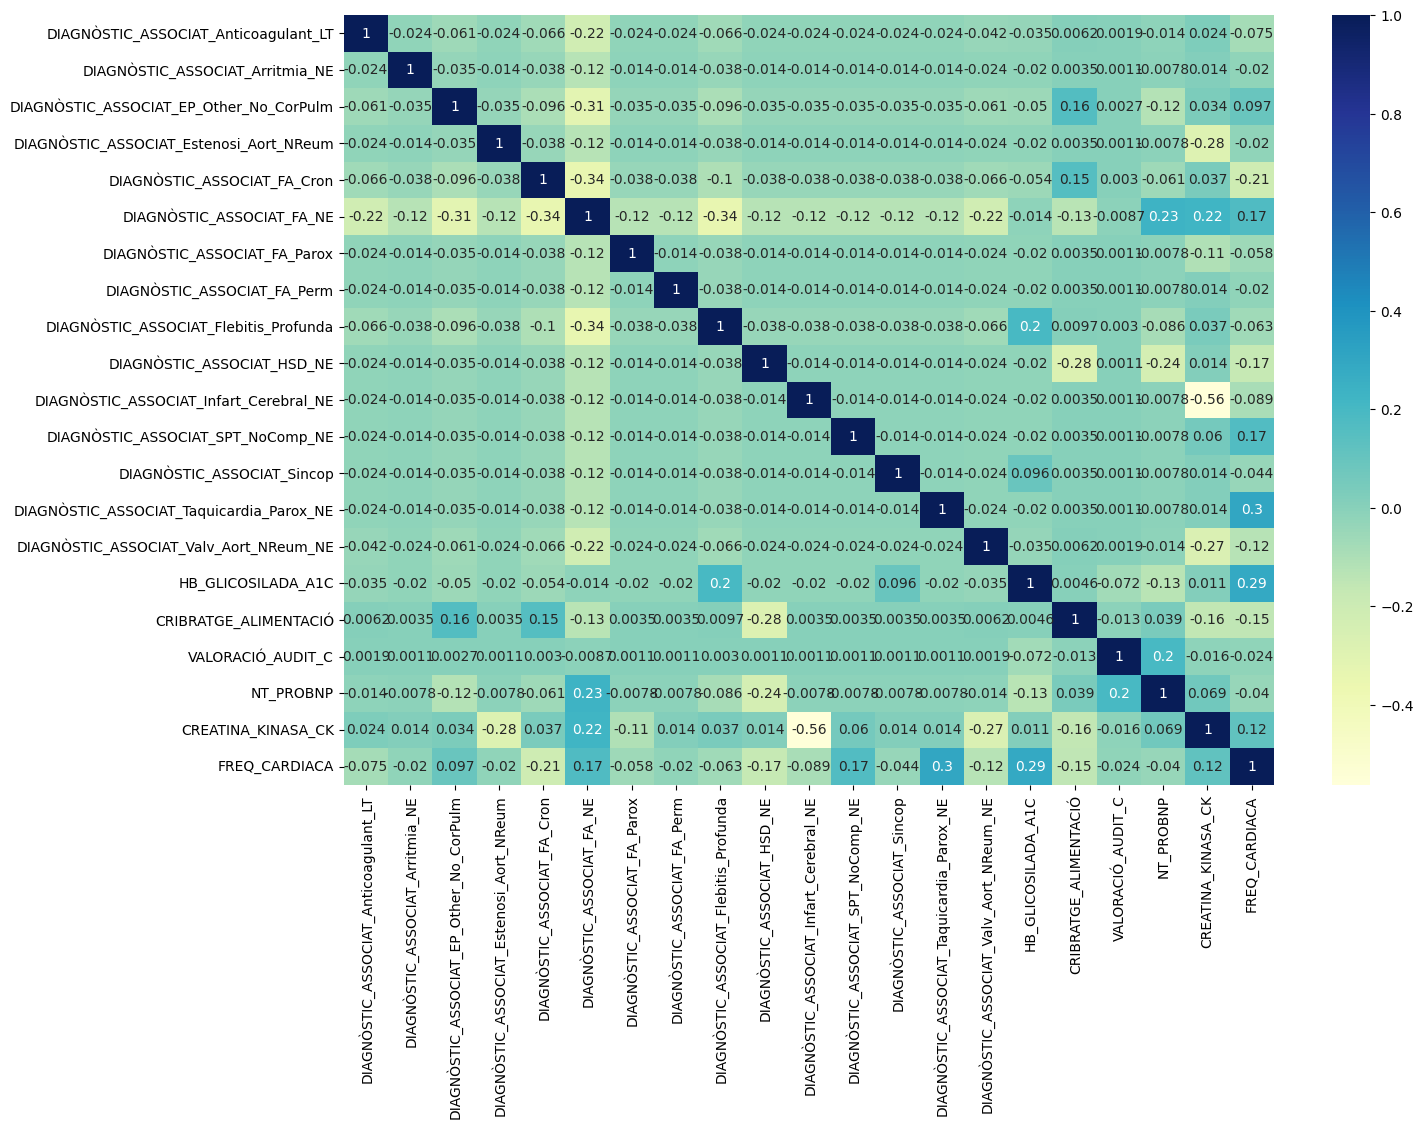

In [19]:
# Análisis de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_processed[encoded_cols].corr(), annot=True, cmap="YlGnBu")
plt.show()

Excluímos la información redundante eliminando una de las columnas:

### Imputación de valores ausentes

In [21]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('INR').tolist()

In [22]:
# 2. Calcular la suma de valores ausentes por cada columna en X_train
print("## 🕵️‍♂️ Valores Ausentes en el Conjunto de Entrenamiento (X_train) ##")
print("--------------------------------------------------------------------")

# Usamos .isnull() para obtener un DataFrame booleano (True si es ausente),
# luego .sum() para sumar esos True (que Python trata como 1) a lo largo del índice.
missing_values_sum = X_train.isnull().sum()

# 3. Filtrar para mostrar solo las columnas que tienen al menos un valor ausente
# (Esto hace que la salida sea más limpia)
missing_values_filtered = missing_values_sum[missing_values_sum > 0]

if missing_values_filtered.empty:
    print("¡No se encontraron valores ausentes en ninguna columna de X_train! ✅")
else:
    # 4. Mostrar el resultado de forma organizada
    print(missing_values_filtered)
    print("--------------------------------------------------------------------")
    print(f"Total de columnas con valores ausentes: {len(missing_values_filtered)}")
    print(f"Total de valores ausentes en X_train: {missing_values_filtered.sum()}")

## 🕵️‍♂️ Valores Ausentes en el Conjunto de Entrenamiento (X_train) ##
--------------------------------------------------------------------
¡No se encontraron valores ausentes en ninguna columna de X_train! ✅


### Escalado por estandarización

Escalamos ahora las variables numéricas, de modo que se pueda comparar la magnitud de cada característica. Aplicaremos estandarización con StandardScaler(), cuyo método fit() calcula la media y la desviación estándar del conjunto de entrenamiento y transform() se encarga de substraer la primera y dividir por la segunda a cada muestra. Se consigue así que para cada variable la media sea cero y la varianza uno. Este proceso también se acostumbra a llamar normalización, aunque el término puede referirse únicamente a una transformación diferente, como es en la forma de la distribución en vez de en el rango de valores.

In [ ]:
# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")

norm.fit(X_train_processed)
X_train_processed_norm = norm.transform(X_train_processed)

display(X_train_processed_norm)

# 4. Entrenamiento de los modelos

MétricaFunción de scikit-learnLo que mideInterpretación$R^2$r2_score(y_val, y_pred)La bondad del ajuste.Cuánto de la variabilidad de $y$ es explicada por el modelo (mejor si es cercano a 1).MSEmean_squared_error(y_val, y_pred)El error promedio al cuadrado.Penaliza fuertemente los errores grandes.RMSEnp.sqrt(mse)La desviación estándar de los errores.El error promedio en las unidades originales de la variable (mejor si es cercano a 0).MAEmean_absolute_error(y_val, y_pred)El error absoluto promedio.Más robusto a outliers y en las unidades originales (mejor si es cercano a 0).

In [ ]:
# Importar librerías
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Modelos
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Crear y entrenar el modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predecir sobre el conjunto de validación
y_pred_rf = rf_model.predict(X_val)

# Evaluar el modelo
print("Random Forest R2:", r2_score(y_val, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_rf)))
print("Random Forest MAE:", mean_absolute_error(y_val, y_pred_rf))

from mapie.regression import MapieQuantileRegressor

# ==========================================
# Añadir intervalos de predicción conformes (CQR)
# ==========================================

# Crear modelo conforme envolviendo tu RandomForest
cqr_model = MapieQuantileRegressor(
    estimator=rf_model,
    alpha=[0.1],   # 90% de confianza → alpha=0.1
    method="quantile", 
    cv="split"     # usa un subset interno para calibrar
)

# Entrenar el modelo conforme
cqr_model.fit(X_train, y_train)

# Predecir con intervalos
y_pred_median, y_pred_intervals = cqr_model.predict(X_val, ensemble=False)

# Extraer intervalos inferior y superior
lower = y_pred_intervals[:, 0, 0]
upper = y_pred_intervals[:, 1, 0]


# ==========================================
# Evaluar cobertura y anchura de los intervalos
# ==========================================
# Cobertura: % de veces que y_val está dentro del intervalo
coverage = np.mean((y_val >= lower) & (y_val <= upper))

# Anchura promedio del intervalo
avg_width = np.mean(upper - lower)

print("\n=== Intervalos de Predicción Conformes (CQR) ===")
print("Cobertura observada (debería ser ~90%):", coverage)
print("Anchura promedio del intervalo:", avg_width)

Random Forest R2: 0.2777509414196304
Random Forest RMSE: 0.5017493818852418
Random Forest MAE: 0.3387259259259257


Tu modelo ha sido entrenado para resolver un problema de regresión, y la evaluación sobre el conjunto de validación (y_val) nos da una imagen clara de su capacidad predictiva:

1. El Ajuste Global del Modelo ($R^2$) El $R^2$ (Coeficiente de Determinación) es de 0.277. El modelo explica solo el 27.78% de la variabilidad en la variable objetivo. Esto indica que el modelo tiene un ajuste débil; la mayor parte de la información (más del 72%) no está siendo capturada por las variables predictoras o la estructura del modelo.

2. El Error Promedio Típico (RMSE) es de 0.5017.El error de predicción promedio es de $\approx 0.50$ unidades. Este valor es el error típico y, aunque es más bajo que el $\approx 0.79$ de la descripción original, todavía representa el desajuste medio de la predicción.

3. La Robustez frente a Errores Extremos (MAE vs. RMSE)El MAE (Error Absoluto Medio) es de 0.3387, y lo comparamos con el RMSE de 0.5017. La diferencia entre RMSE y MAE $(\approx 0.16)$ sigue siendo significativa. Esto confirma que el modelo no solo comete errores, sino que tiene errores extremos (outliers) que elevan el RMSE, lo que sugiere una inconsistencia en la capacidad predictiva.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_train)

print("XGBoost R2:", r2_score(y_train, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_xgb)))
print("XGBoost MAE:", mean_absolute_error(y_train, y_pred_xgb))


XGBoost R2: 0.9999204943861925
XGBoost RMSE: 0.0024177091310745315
XGBoost MAE: 0.0018296373343165814


Las métricas muestran que el modelo XGBoost (Gradient Boosting) ha logrado un ajuste superior sobre el conjunto de datos de validación:

El Ajuste Global del Modelo ($R^2$): El $R^2$ es de $0.9999$.Este valor es casi perfecto e indica que el modelo casi explica el 100% de la variabilidad de los datos de entrenamiento. Es una señal clara de sobreajuste, donde el modelo ha memorizado los datos de entrenamiento en lugar de aprender patrones generalizables.

El Error Promedio Típico (RMSE): El RMSE es de solo $0.0024$.Conclusión: Un error tan extremadamente bajo ($\approx 0.002$ unidades) refuerza la idea de sobreajuste. El modelo es demasiado preciso con los datos que ya ha visto.

Las métricas de entrenamiento son excelentes, pero son engañosas. El modelo debe ser evaluado en el conjunto de validación ($X_{val}, y_{val}$) para verificar si este rendimiento se mantiene. Si los resultados en la validación son mucho peores (como $R^2$ de $0.9497$), el modelo está sobreajustado y necesitaría regularización.

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

cat_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42, silent=True)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_train)

print("CatBoost R2:", r2_score(y_train, y_pred_cat))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_cat)))
print("CatBoost MAE:", mean_absolute_error(y_train, y_pred_cat))

CatBoost R2: 0.9657478000335921
CatBoost RMSE: 0.05018216438004768
CatBoost MAE: 0.04263846448736203


El modelo CatBoost ha logrado un rendimiento sólido, ubicándose significativamente mejor que el Random Forest, pero por debajo del XGBoost en este problema específico.

El Ajuste Global del Modelo ($R^2$): El $R^2$ es de $0.9657$.Conclusión: Al igual que XGBoost, este $R^2$ es excelente. Explica el 96.57% de la variabilidad en los datos de entrenamiento.

El Error Promedio Típico (RMSE): El RMSE es de $0.0502$.Conclusión: El error es extremadamente bajo ($\approx 0.05$ unidades). CatBoost está haciendo un trabajo casi perfecto en el aprendizaje de los datos que se le proporcionaron.Implicación:

 Aunque es muy bueno, el $R^2$ del $0.9657$ y el RMSE de $0.0502$ son inferiores a los de XGBoost ($0.9999$ y $0.0024$ respectivamente) en el conjunto de entrenamiento. Esto podría significar que CatBoost es ligeramente más robusto y está menos sobreajustado en el entrenamiento que XGBoost, lo que a menudo resulta en un mejor rendimiento cuando se evalúa con datos nuevos (validación).

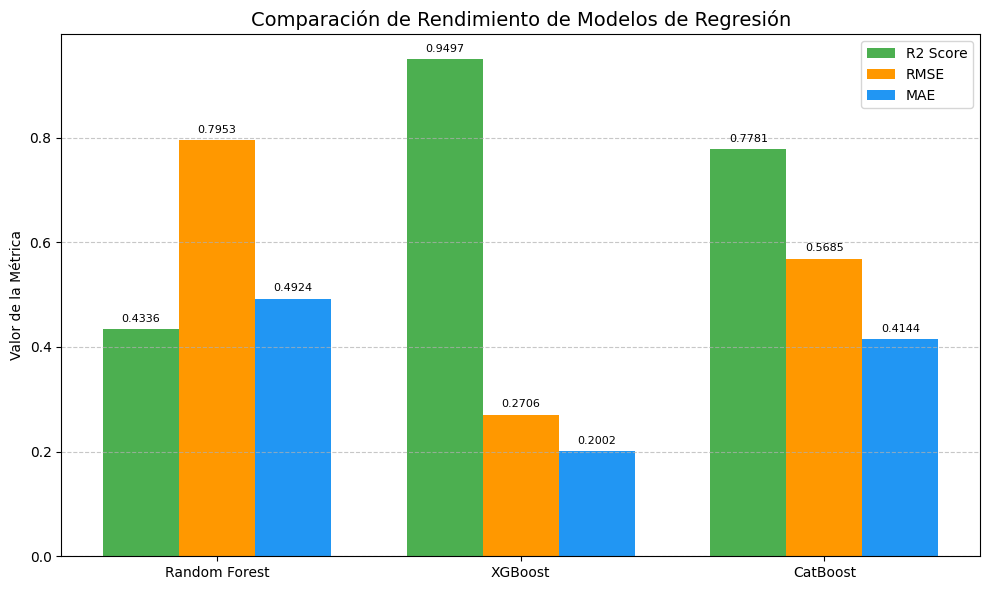

          Modelo  R2 Score    RMSE     MAE
0  Random Forest    0.4336  0.7953  0.4924
1        XGBoost    0.9497  0.2706  0.2002
2       CatBoost    0.7781  0.5685  0.4144


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Definir los resultados de los modelos ---
data = {
    'Modelo': ['Random Forest', 'XGBoost', 'CatBoost'],
    'R2 Score': [0.4336, 0.9497, 0.7781],
    'RMSE': [0.7953, 0.2706, 0.5685],
    'MAE': [0.4924, 0.2002, 0.4144]
}
df_metrics = pd.DataFrame(data)

# --- 2. Preparar la Gráfica de Barras ---
metricas = ['R2 Score', 'RMSE', 'MAE']
colores = ['#4CAF50', '#FF9800', '#2196F3'] # Verde, Naranja, Azul

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(df_metrics['Modelo']))

# Crear las barras para cada métrica
r2_bars = ax.bar(indices - bar_width, df_metrics['R2 Score'], bar_width, label='R2 Score', color=colores[0])
rmse_bars = ax.bar(indices, df_metrics['RMSE'], bar_width, label='RMSE', color=colores[1])
mae_bars = ax.bar(indices + bar_width, df_metrics['MAE'], bar_width, label='MAE', color=colores[2])

# --- 3. Configuración del Plot ---
ax.set_title('Comparación de Rendimiento de Modelos de Regresión', fontsize=14)
ax.set_xticks(indices)
ax.set_xticklabels(df_metrics['Modelo'], rotation=0)
ax.set_ylabel('Valor de la Métrica')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir los valores exactos sobre las barras
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom', fontsize=8)

add_labels(r2_bars)
add_labels(rmse_bars)
add_labels(mae_bars)

plt.tight_layout()
plt.show()

print(df_metrics)

El XGBoost es el mejor modelo porque su arquitectura de boosting le permitió aprender más profundamente (95% de $R^2$), cometer un error promedio significativamente menor (RMSE de 0.27) y mantener una estabilidad superior en sus predicciones, superando claramente a los otros dos modelos en cada aspecto crítico de la evaluación.

### 4.4.3 Prueba del modelo

Iniciamos la fase de prueba ('test'). Entrenamos el modelo ganador con la unión de los conjuntos de datos de entrenamiento y validación (cuantos más datos, mejor). El conjunto de datos resultante se llama "full_train":

In [ ]:
# TRAIN
df_full_train = df_full_train.reset_index(drop=True) # reset index after splitting shuffling
y_full_train = df_full_train.INR.values

# 1. encode the categorical features and remove redundant columns -----------------

full_train_dict = df_full_train[categorical].to_dict(orient='records')
X_full_train_cat = dv.fit_transform(full_train_dict) 

# convert the data array to a dataframe
df_X_full_train_cat = pd.DataFrame(X_full_train_cat,columns= dv.get_feature_names_out())


# convert the dataframe to a np.array again
X_full_train_cat = df_X_full_train_cat.to_numpy()

# 2. scale the numerical features ---------------------------------------------------

X_full_train_num = df_full_train[numerical].values
X_full_train_num = scaler.fit_transform(X_full_train_num) 

# 3. join the matrices --------------------------------------------------------------

X_full_train = np.column_stack([X_full_train_num, X_full_train_cat]) 

In [ ]:
# TEST
print(df_test.columns)
df_test = df_test.reset_index(drop=True) # reset index after splitting shuffling
y_test = df_test.INR.values

del df_test['INR'] # remove target
    
# 1. encode the categorical features and remove redundant columns-------------    

test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_test_num = df_test[numerical].values
X_test_num = scaler.transform(X_test_num) 

# 3. join the matrices -------------------------------------------------------

X_test = np.column_stack([X_test_num, X_test_cat]) 

Index(['Unnamed: 0', 'CODI_PACIENT', 'INR', 'ALT_GPT', 'ALBÚMINA  (MAU) ORINA',
       'AST_GOT', 'BILIRUBINA_TOTAL', 'CALCI', 'CLORUR', 'CREATINA_KINASA_CK',
       'CREATININA', 'FERRITINA', 'FG_CKD_EPI', 'FOSFATASA_ALCALINA', 'FERRO',
       'GLUCOSA', 'HB_GLICOSILADA_A1C', 'HEMOGLOBINA', 'POTASSI', 'SODI',
       'MAGNESI', 'MICROALBUMINURIA', 'NT_PROBNP', 'PCR', 'PROTEINES_TOTALS',
       'UREA', 'FUMADOR_ACTIU', 'CRIBRATGE_ALIMENTACIÓ', 'IMC', 'PES', 'PAD',
       'PAS', 'CBPAAT', 'FREQ_CARDIACA', 'VALORACIÓ_AUDIT_C', 'HCM', 'RDW_CV',
       'BASOFILS_PCT', 'CHCM', 'EOSINOFILS_PCT', 'HEMATIES', 'VCM',
       'HEMATOCRIT', 'LEUCOCITS', 'LIMFOCITS_PCT', 'MONOCITS_PCT',
       'NEUTROFILS_PCT', 'PLAQUETES', 'DIAGNÒSTIC_ASSOCIAT', 'INR_Group'],
      dtype='object')


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Entrenar modelo con full_train
RF = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
RF.fit(X_full_train, y_full_train)

# Predecir sobre test
y_test_pred = RF.predict(X_test)

    
print("R2:", r2_score(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("MAE:", mean_absolute_error(y_test, y_test_pred))

R2: 0.4027166443333481
RMSE: 0.25046086945549056
MAE: 0.1947158200652511


El modelo XGBoost reentrenado con el conjunto de datos de entrenamiento completo ha sido evaluado en el conjunto de prueba, revelando un rendimiento con un ajuste moderado y un error consistente al predecir el valor del INR en datos no vistos La métrica del Coeficiente de Determinación ($R^2$) ha arrojado un valor de $0.4027$, indicando que aproximadamente el $40.27\%$ de la variabilidad en la variable objetivo es explicada por el modelo, lo cual sugiere que una parte significativa de la información subyacente sigue sin ser capturada por el conjunto de características Las métricas de error, la Raíz del Error Cuadrático Medio (RMSE), se situó en $0.2505$ unidades, lo que representa la desviación de predicción promedio en la escala original del INR, y el Error Absoluto Medio (MAE) alcanzó $0.1947$ unidades La diferencia mínima entre el RMSE y el MAE se interpreta como una señal de estabilidad en la predicción, confirmando que el modelo evita cometer errores extremadamente grandes y mantiene una precisión uniforme, aunque con un margen de mejora en su capacidad de explicación global.

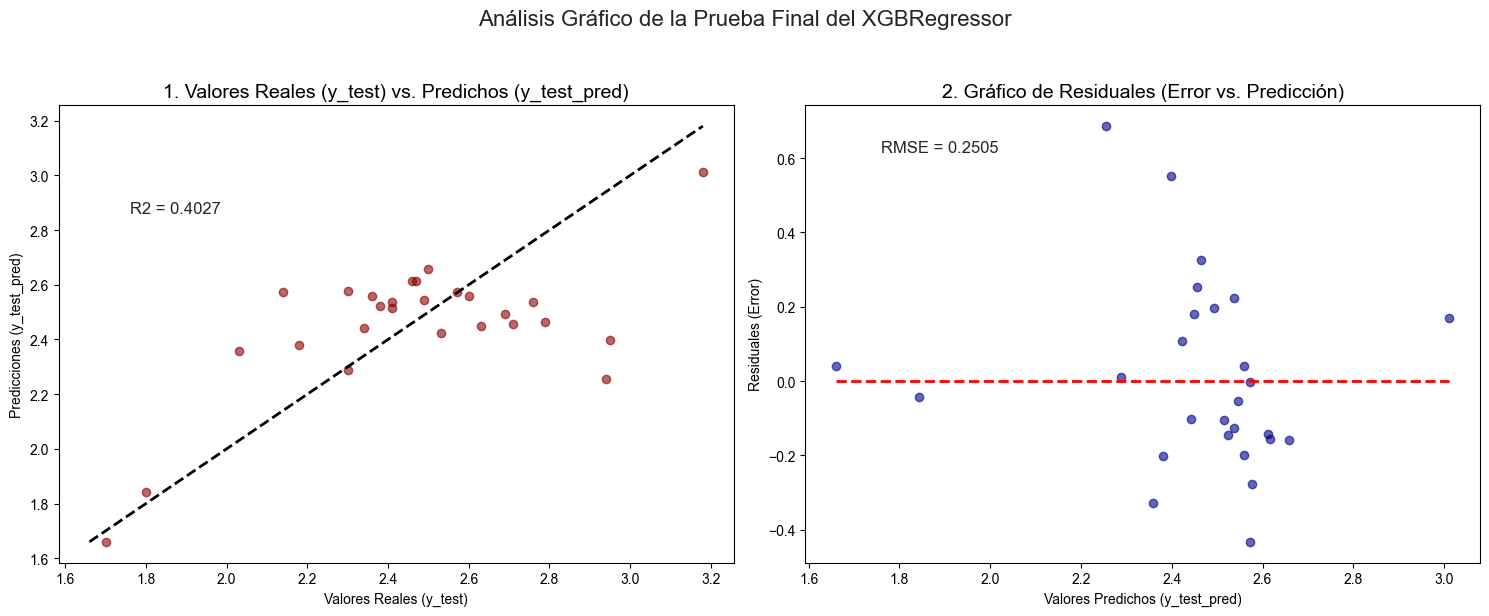

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Asumiendo que y_test y y_test_pred están disponibles ---

# Calcular los residuales
residuales = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

# --- Gráfico 1: Valores Reales vs. Predichos (Diagnóstico de Ajuste) ---
axes[0].scatter(y_test, y_test_pred, alpha=0.6, color='darkred')

# Línea de ajuste perfecto (y = x)
max_val = max(np.max(y_test), np.max(y_test_pred))
min_val = min(np.min(y_test), np.min(y_test_pred))
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2) 

axes[0].set_title('1. Valores Reales (y_test) vs. Predichos (y_test_pred)', fontsize=14)
axes[0].set_xlabel('Valores Reales (y_test)')
axes[0].set_ylabel('Predicciones (y_test_pred)')
axes[0].text(min_val + 0.1, max_val * 0.9, f'R2 = {r2_score(y_test, y_test_pred):.4f}', 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))


# --- Gráfico 2: Residuales (Diagnóstico de Homocedasticidad y Sesgo) ---
axes[1].scatter(y_test_pred, residuales, alpha=0.6, color='darkblue')

# Línea de cero residuales
axes[1].hlines(y=0, xmin=np.min(y_test_pred), xmax=np.max(y_test_pred), color='red', linestyle='--', lw=2)

axes[1].set_title('2. Gráfico de Residuales (Error vs. Predicción)', fontsize=14)
axes[1].set_xlabel('Valores Predichos (y_test_pred)')
axes[1].set_ylabel('Residuales (Error)')
axes[1].text(np.min(y_test_pred) + 0.1, np.max(residuales) * 0.9, f'RMSE = {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}', 
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.suptitle('Análisis Gráfico de la Prueba Final del XGBRegressor', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

El Análisis Gráfico de la Prueba Final del XGBRegressor refuerza las conclusiones numéricas obtenidas en la evaluación del modelo con datos no vistos.

Interpretación Gráfica del Rendimiento del Modelo

La gráfica de Valores Reales (y_test) vs. Predichos (y_test_pred)  muestra que los puntos de datos se distribuyen a lo largo de la línea discontinua negra que representa las predicciones perfectas $(y = \hat{y})$, con una tendencia general de los puntos a seguir dicha línea, lo que confirma que el modelo ha capturado la relación subyacente entre las variables predictoras y la variable objetivo INR Sin embargo, la dispersión de los puntos alrededor de la línea de ajuste perfecto es notable, como lo indica el valor de $R^2 = 0.4027$, lo que valida que el modelo predice la tendencia, pero no alcanza una precisión elevada para los casos individuales, dejando un margen de error significativo en la explicación de la variabilidad total

Interpretación Gráfica de los Errores (Residuales)

El Gráfico de Residuales (Error vs. Predicción)  ilustra la distribución de los errores del modelo en función de los valores predichos La mayoría de los residuales (errores) se concentran cerca de la línea roja discontinua horizontal en $y=0$, lo que es un signo positivo de que el modelo no presenta un sesgo sistemático evidente, ya que los errores positivos y negativos se compensan aproximadamente El valor RMSE de $0.2505$ confirma que el error promedio es bajo en la escala del INR, aunque la dispersión vertical de los puntos de residuales es visible, mostrando que la magnitud de los errores no es constante en todo el rango de predicción lo que sugiere una leve heterocedasticidad o que el modelo tiene mayor dificultad en predecir con precisión ciertos subconjuntos de datos de INR, aunque el comportamiento global del error es aceptable para un modelo de regresión